In [1]:
import scipy as sci
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
%matplotlib widget

file = 'Iris.csv'
data = pd.read_csv(file, index_col=0, header=0).reset_index(drop=True)
N = len(data.index)

cats = data["Species"].unique()
cats1 = dict(zip(cats, range(len(cats))))
cats2 = dict(zip(range(len(cats)), cats))
data["Species"] = data["Species"].apply(lambda x: cats1[x])

x = data.index


### Learner measures

In [2]:
# lower bound to sample size
def PAC_eta(H_norm, delta, epsilon):
    return (np.ln(H_norm) - np.ln(delta))/epsilon

# lower bound to generalization error


def PAC_delta(H_norm, epsilon, eta):
    return H_norm/np.exp(eta*epsilon)


# Sampling

## Distributions

Text(0.5, 0, 'Sample Index')

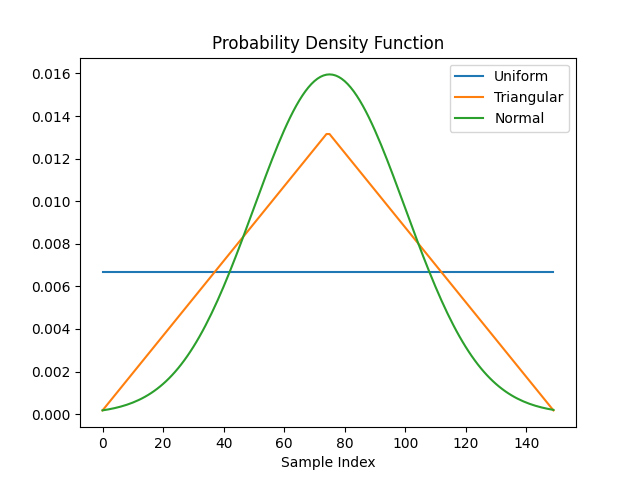

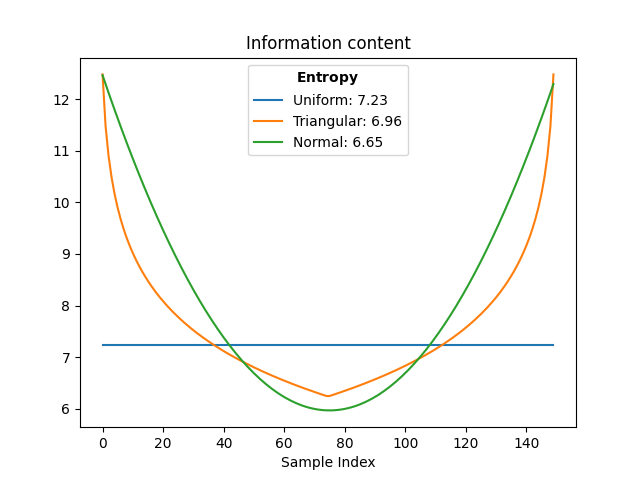

In [3]:
pdf_names = ["Uniform", "Triangular", "Normal"]


def pdf(pdf, x): return {
    "Uniform": sci.stats.uniform.pdf(x, 0, N),
    "Triangular": sci.stats.triang.pdf(x, 0.5, -1, N+1),
    "Normal": sci.stats.norm.pdf(x, N//2, N//6)}[pdf]


plt.figure()
for name in pdf_names:
    plt.plot(x, pdf(name, x), label=name)
plt.legend()
plt.title("Probability Density Function")
plt.xlabel("Sample Index")

plt.figure()
for name in pdf_names:
    p = pdf(name, x)
    I = np.log2(1/p)
    H = np.sum(-p*np.log2(p))
    plt.plot(x, I, label=f"{name}: {H:.2f}")
plt.legend(title="$\\bf{Entropy}$")
plt.title("Information content")
plt.xlabel("Sample Index")


## Comparison of samples

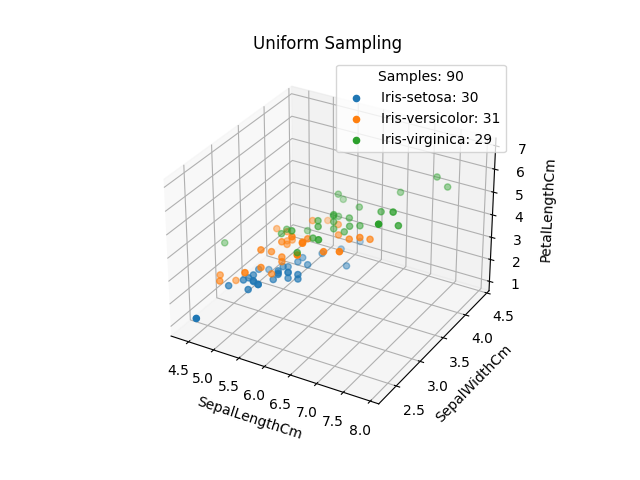

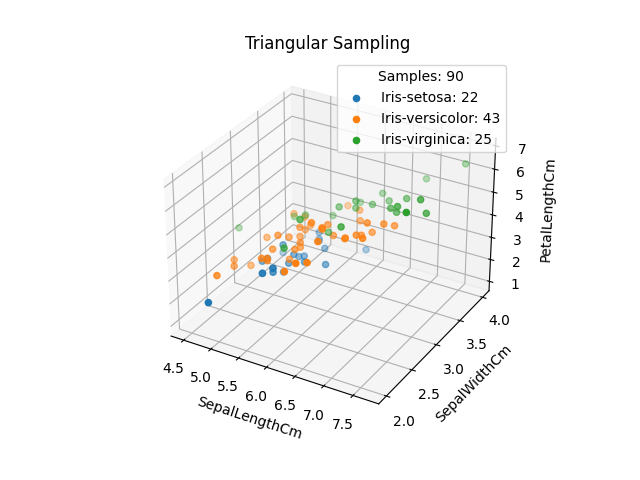

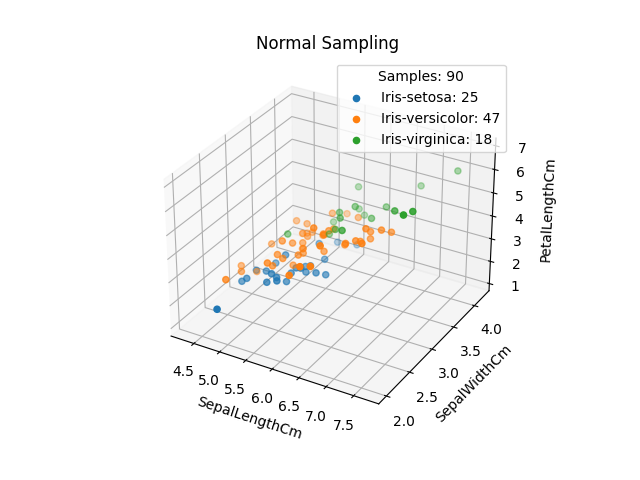

In [4]:
def set_axis_labels(ax, x, y, z):
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)


for name in pdf_names:
    plt.figure()
    ax = plt.axes(projection='3d', title=f"{name} Sampling")
    sample = data.sample(frac=0.6, weights=pdf(name, x))
    total = 0
    for (k, v) in cats1.items():
        total += np.sum(sample["Species"] == v)
        p = sample[sample["Species"] == v]
        ax.scatter(*zip(*p.iloc[:, 0:3].values.tolist()),
                   label=f"{k}: {len(p)}")
    plt.legend(title=f"Samples: {total}")
    set_axis_labels(ax, *p.columns[0:3])


# Training

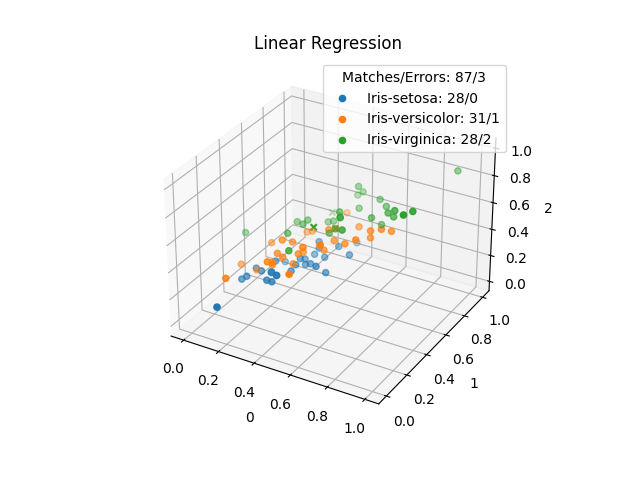

In [6]:
# gets B such that ||Y-XB||^2 is minimized
def regression(X, Y):
    # Adds a 1s column to X to represent a constant parameter
    X = np.append(np.ones(X.shape[0])[:, None], X, axis=1)
    Beta = np.asmatrix(X.T @ X).I @ X.T @ Y
    return Beta


sample = data.sample(frac=0.6, weights=pdf("Uniform", x))
X = sample.iloc[:, :-1]
Y = sample.iloc[:, -1]


def normalize(points):
    points_min = points.min(axis=0)
    points_scale = points.max(axis=0) - points_min
    return (points - points_min) / points_scale


X = normalize(X)
Beta = regression(X, Y)
a = np.mgrid[0:1:0.1, 0:1:0.1, 0:1:0.1, 0:1:0.1]
X = np.append(np.ones(X.shape[0])[:, None], X, axis=1)
Z = np.round(X@Beta)
A = pd.DataFrame(X[:, 1:], index=Y.index)
A['Z'] = Z

plt.figure()
ax = plt.axes(projection='3d', title="Linear Regression")
total = 0
errors = 0
for (k, v) in cats1.items():
    TP = (A["Z"] == v) & (Y == v)
    FP = (A["Z"] == v) & (Y != v)
    errors += np.sum(FP)
    total += np.sum(TP)
    p = A[TP]
    c = ax.scatter(*zip(*p.iloc[:, 0:3].values.tolist()), marker="o",
                   label=f"{k}: {len(p)}/{np.sum(FP)}").get_facecolors()[0]
    if np.sum(FP) > 0:
        p = A[FP]
        ax.scatter(*zip(*p.iloc[:, 0:3].values.tolist()), marker="x", color=c)
plt.legend(title=f"Matches/Errors: {total}/{errors}")
set_axis_labels(ax, *p.columns[0:3])
